# Synthetic Datasets

Imagine you need a very specific dataset for demonstrating or experimenting with various preprocessing techniques and algorithms (or you're a teacher looking for a suitable dataset for a homework). The more criteria you have (e.g. imbalanced classes, redundant features...) the harder it will be to find _the_ perfect dataset (with a reasonable number of samples) online.

Luckily, _scikit-learn_ provides the functionality to generate _toy_ datasets - and a lot of parameters we can use to create exactly what we need, including the number of samples, features (and how many of them are redundant), classes (and their distribution) and much more.

Take a look at some examples:

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

In [39]:
my_random_state = 44
sns.set_palette('deep')

<Axes: xlabel='0', ylabel='1'>

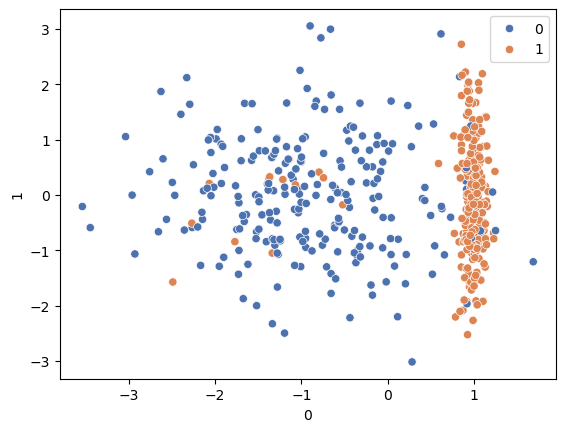

In [40]:
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=0.1, random_state=my_random_state)
sns.scatterplot(data=pd.DataFrame(X), x=0, y=1, hue=y)

<Axes: xlabel='0', ylabel='1'>

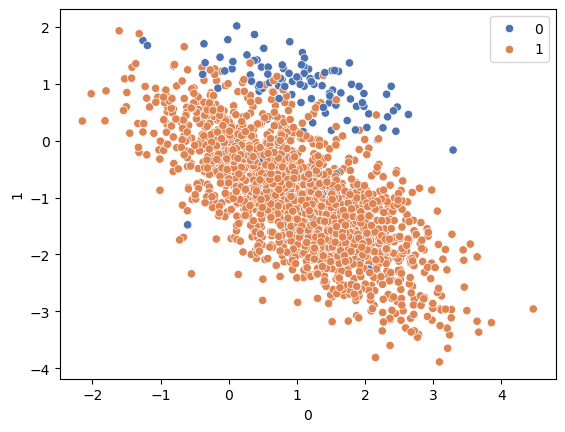

In [41]:
X, y = make_classification(n_samples=2000, n_classes=2, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, weights=[0.05], random_state=my_random_state)
sns.scatterplot(data=pd.DataFrame(X), x=0, y=1, hue=y)

<Axes: xlabel='0', ylabel='1'>

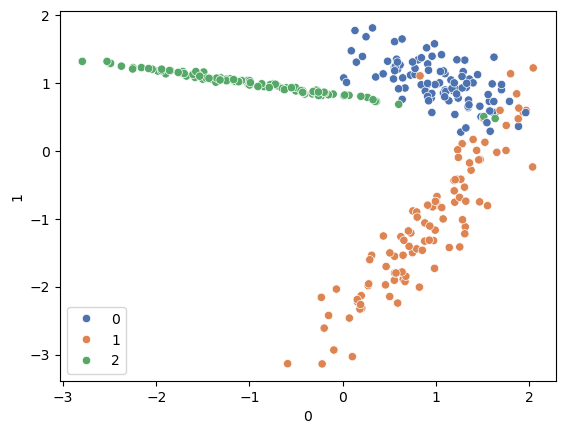

In [42]:
X, y = make_classification(n_samples=300, n_classes=3, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=my_random_state)
sns.scatterplot(data=pd.DataFrame(X), x=0, y=1, hue=y, palette='deep')

<Axes: xlabel='0', ylabel='1'>

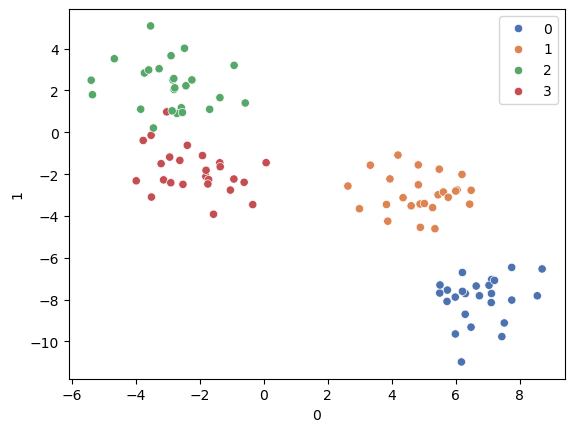

In [43]:
X, y = make_blobs(n_features=2, centers=4, random_state=my_random_state)
sns.scatterplot(data=pd.DataFrame(X), x=0, y=1, hue=y, palette='deep')

For this demo we'll be working with the following toy dataset:

<Axes: xlabel='feature_a', ylabel='feature_b'>

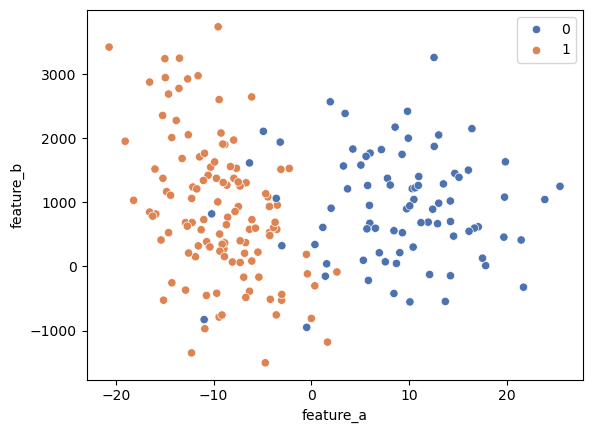

In [44]:
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, weights=[0.4], scale=[1000, 10], flip_y=0.02, random_state=my_random_state)
X = pd.DataFrame(X, columns=['feature_a', 'feature_b'])
sns.scatterplot(data=X, x='feature_a', y='feature_b', hue=y)

In [45]:
pd.Series(y).value_counts()

1    118
0     82
Name: count, dtype: int64

In [46]:
X

,feature_a,feature_b
0,-12.230263,1060.750939
1,-12.869427,684.396741
2,-8.840631,1901.500598
3,5.854873,-216.598786
4,-12.114559,1239.254743
...,...,...
195,6.570887,596.268556
196,-8.265657,1557.812861
197,12.932889,666.979297
198,14.255513,-144.167896


# _k-Nearest-Neighbors_ Algorithm

We're going to use our synthetic dataset for getting to know one of the most fundamental and simple machine learning algorithms: The _k-nearest-neighbors_ (or _KNN_) algorithm, developed by _US Air Force_ statisticians Evelyn Fix and Joseph Lawson Hodges in an unpublished 1951 paper.

Its beauty is its simplicity.

Suppose we want to classify a data point:

1. We calculate the distances to existing data points (i.e. the training data).
1. We determine the $k$ closest points - the _nearest neighbors_.
1. We let each neighbor vote for their class. The majority vote wins and is used to predict the label.

The following figure (source: _DataCamp_) illustrates the algorithm:

![](images/knn.png)

N.B.: We can distinguish two types of _kNN_-algorithms: _Eager_ and _lazy_ learners. Eager learners use the training points to construct a model, which is used for predicting new points. This results in higher training and lower prediction times. On the other hand, lazy learners don't learn at all - they simply store the training instances and use them for calculating the distances and voting at the time of prediction. Unlike eager learning methods, lazy learners do less work in the training phase and more work in the testing phase to make a classification.

Let's try it out on our synthetic dataset. Based on the plots above and our newly gained knowledge about the algorithm it should perform reasonably well:

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [48]:
knn_model = KNeighborsClassifier()

cross_val_score(knn_model, X, y).mean()

0.5050000000000001

50% is quite underwhelming to say the least. What happened? Let's investigate by plotting the decision regions:

In [49]:
from mlxtend.plotting import plot_decision_regions

c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<Axes: >

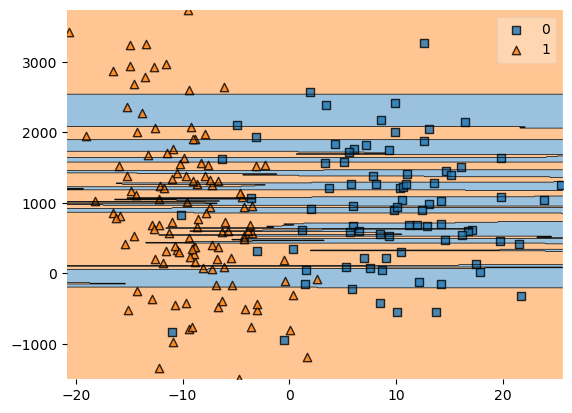

In [50]:
knn_model.fit(X, y)

plot_decision_regions(X=X.to_numpy(dtype=float), y=y, clf=knn_model, zoom_factor=6)

# Feature Scaling

The suspicious, long horizontal regions in the plot above indicate, that there's something wrong with the distance calculations.

Take a look at the following example, containing fictional flats:

In [51]:
data_flats = pd.DataFrame({'no_of_rooms': [2, 4, 2, 4, 2, 3], 'year_built': [2005, 2006, 1990, 2018, 2001, 1997]})
data_flats

,no_of_rooms,year_built
0,2,2005
1,4,2006
2,2,1990
3,4,2018
4,2,2001
5,3,1997


The _Euclidean distance_ between flat _0_ and flat _1_ can be calculated as follows:

In [52]:
((2-4)**2 + (2005-2006)**2)**0.5

2.23606797749979

For comparison, the distance between flat _0_ and flat _4_ is:

In [53]:
((2-2)**2 + (2005-2001)**2)**0.5

4.0

So according to the distance, the 2005 two-room flat is more similar to the 2006 four-room-flat than to the 2001 two-room-flat - because of the broad range in the `year` column, the number of rooms plays only a minor role in determining the similarity between samples.

A solution for this problem, that affects both _distance-based_ machine learning algorithms like _kNN_ as well as approaches using weighted sums like _neural networks_, is **_feature scaling_** - i.e. rescaling the ranges of the variables, so that each one contributes approximately proportionately to the final distance.

An intuitive approach is simply transforming the data into a range between $0$ and $1$ according to its minimum and maximum values:

$$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$$

While being easy to understand, how does the so called _min-max-normalization_ react to outliers?

Let's create another synthetic dataset to investigate - this time more _manually_ using _numpy_:

In [54]:
import numpy as np

<Axes: ylabel='Density'>

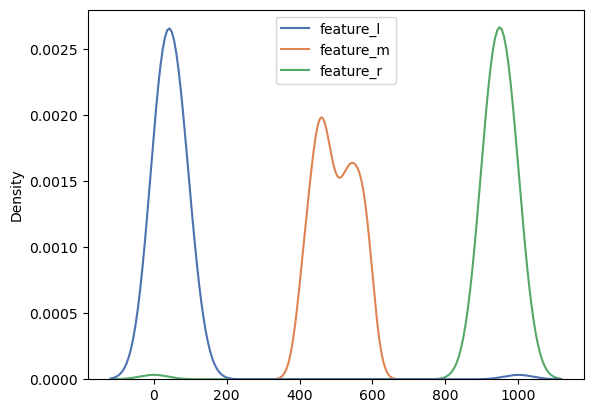

In [55]:
data_outliers = pd.DataFrame()
# 100 points between 1 and 100, 1 outlier at 1000
data_outliers['feature_l'] = np.append(np.random.randint(low=0, high=100, size=100), [1000])
# 101 points between 400 and 600, no outliers
data_outliers['feature_m'] = np.random.randint(low=400, high=600, size=101)
# 100 points between 900 and 1000, 1 outlier at 0
data_outliers['feature_r'] = np.append(np.random.randint(low=900, high=1000, size=100), [0])

sns.kdeplot(data=data_outliers)

We can now apply _min-max-normalization_ using _sklearn_'s `MinMaxScaler`:

In [56]:
from sklearn.preprocessing import MinMaxScaler

<Axes: ylabel='Density'>

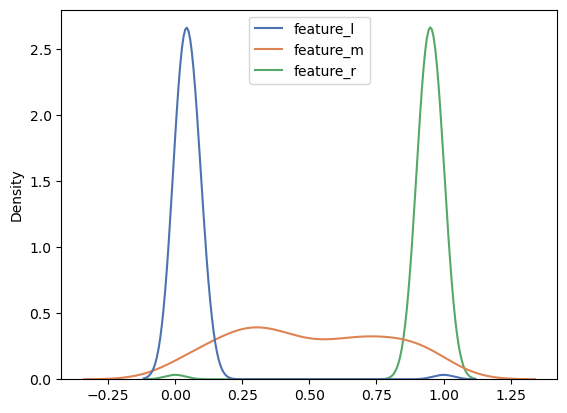

In [57]:
scaler = MinMaxScaler()

data_outliers_scaled = pd.DataFrame(scaler.fit_transform(data_outliers))
data_outliers_scaled.index = data_outliers.index
data_outliers_scaled.columns = data_outliers.columns

sns.kdeplot(data=data_outliers_scaled)

As you can see, the feature without outliers (`feature_m`) is now evenly distributed between $0$ and $1$, while 100 points in the other two features got _squished_ into the opposite sides of their one single outliers!

An alternative to _min-max-normalization_ is described in _Data Mining: Practical Machine Learning Tools and Techniques_ (2016, by Witten et al.) as follows:

> Another […] technique is to calculate the statistical mean and standard deviation of the attribute values, subtract the mean from each value, and divide the result by the standard deviation. This process is called standardizing a statistical variable and results in a set of values whose mean is zero and standard deviation is one.

Mathematically, _standardization_ (also known as _Z-Score-Normalization_) is denoted as...

$$x' = \frac{x - \bar{x}}{\sigma}$$

...with $\bar{x}$ being the mean and $\sigma$ being the standard deviation.

While the outliers still have an effect on calculating the mean and standard deviation, the data gets _centered_ around $0$ now.

We can easily apply standardization using _sklearn_'s `StandardScaler`:

In [58]:
from sklearn.preprocessing import StandardScaler

<Axes: ylabel='Density'>

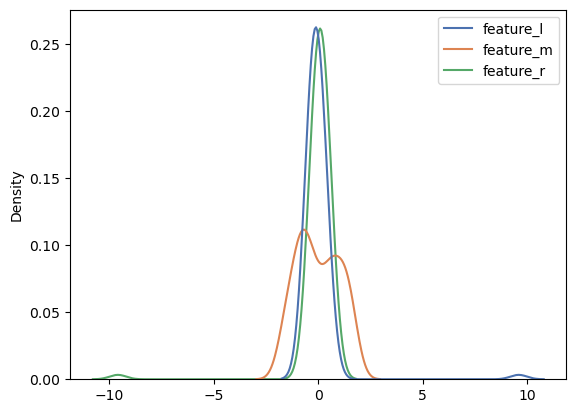

In [59]:
scaler = StandardScaler()

data_outliers_scaled = pd.DataFrame(scaler.fit_transform(data_outliers))
data_outliers_scaled.index = data_outliers.index
data_outliers_scaled.columns = data_outliers.columns

sns.kdeplot(data=data_outliers_scaled)

An even more _robust_ technique for _scaling_ is implemented in _sklearn_'s `RobustScaler`: In this approach the _interquartile range_ (_IQR_) and median are used for the standardization. This way the outliers don't skew the distribution, as shown in the following plot:

In [60]:
from sklearn.preprocessing import RobustScaler

<Axes: ylabel='Density'>

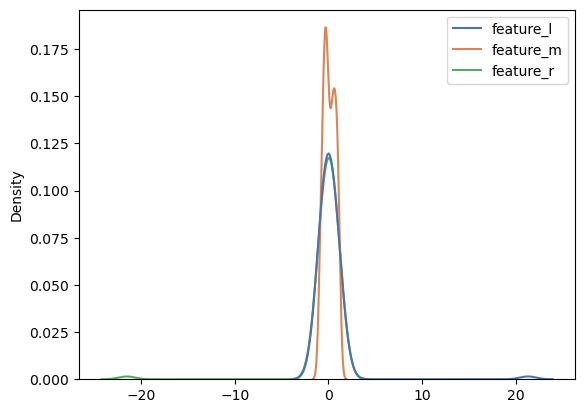

In [61]:
scaler = RobustScaler()

data_outliers_scaled = pd.DataFrame(scaler.fit_transform(data_outliers))
data_outliers_scaled.index = data_outliers.index
data_outliers_scaled.columns = data_outliers.columns

sns.kdeplot(data=data_outliers_scaled)

Let's see if we can improve our miserable _kNN_-accuracy of ~50% by applying feature scaling on our synthetic dataset from before. Since we don't have any outliers, we're simply going to use the `StandardScaler`:

In [62]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.index = X.index
X_scaled.columns = X.columns

Text(0.5, 1.0, 'After')

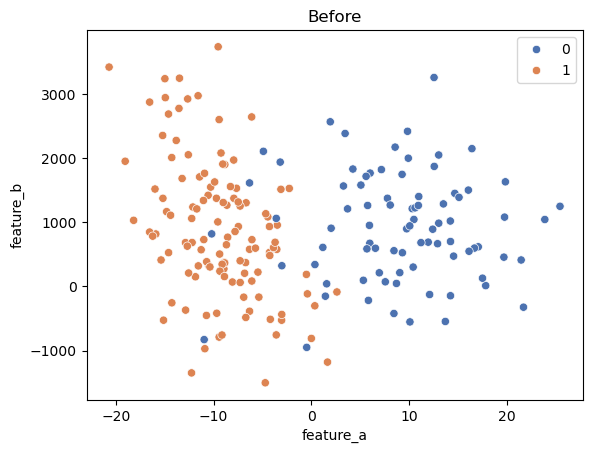

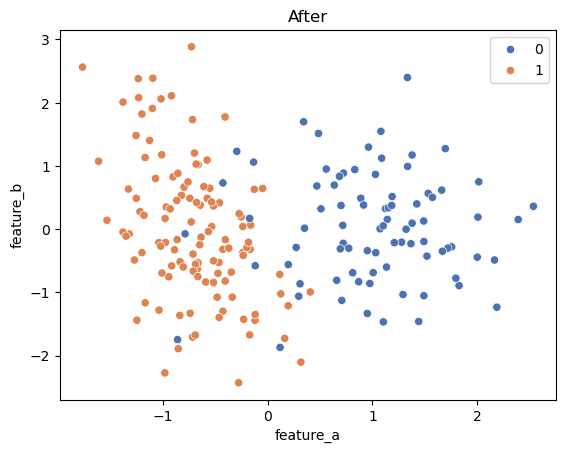

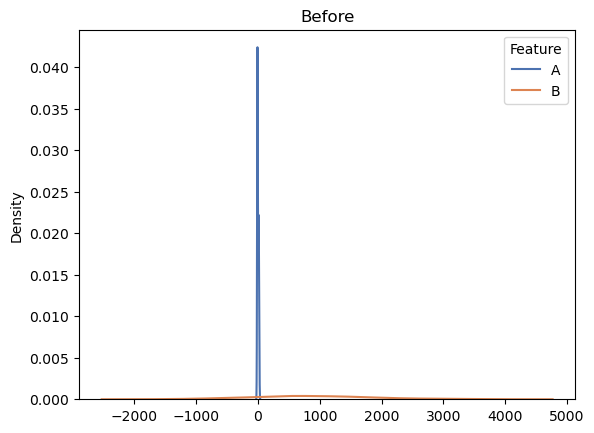

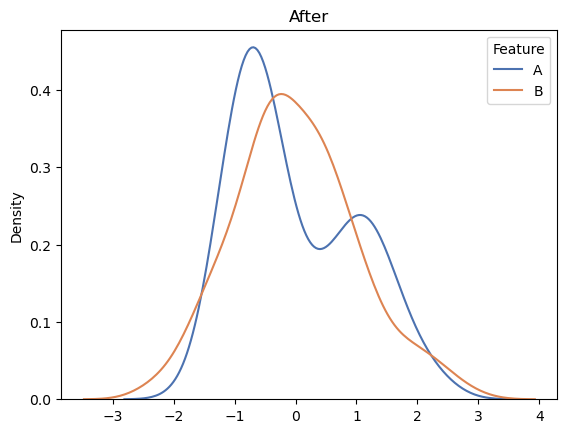

In [63]:
sns.scatterplot(data=X, x='feature_a', y='feature_b', hue=y)
plt.title('Before')

plt.figure()
sns.scatterplot(data=X_scaled, x='feature_a', y='feature_b', hue=y)
plt.title('After')

plt.figure()
sns.kdeplot(data=X, x='feature_a')
sns.kdeplot(data=X, x='feature_b')
plt.xlabel(None)
plt.legend(title='Feature', loc='upper right', labels=['A', 'B'])
plt.title('Before')

plt.figure()
sns.kdeplot(data=X_scaled, x='feature_a')
sns.kdeplot(data=X_scaled, x='feature_b')
plt.xlabel(None)
plt.legend(title='Feature', loc='upper right', labels=['A', 'B'])
plt.title('After')

In [64]:
knn_model = KNeighborsClassifier()

cross_val_score(knn_model, X_scaled, y).mean()

0.9450000000000001

Nearly 95% - scaling our data had a huge effect on our _kNN_-model's performance!

# _kNN_ Hyperparameters

As always, we can also try to improve our model's performance by tuning the hyperparameters. The obviously most important parameter of the _kNN_-algorithm is the number of nearest neighbors that are considered for the classification. While considering few neighbors can lead to overfitting, a big value for $k$ can lead to underfitting.

Let's experiment with different values for $k$ by plotting the decision regions:

c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWa

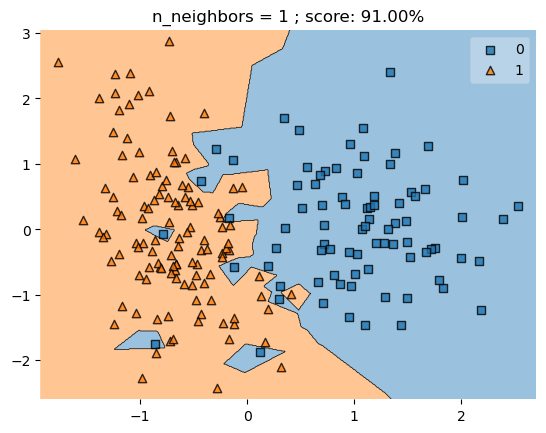

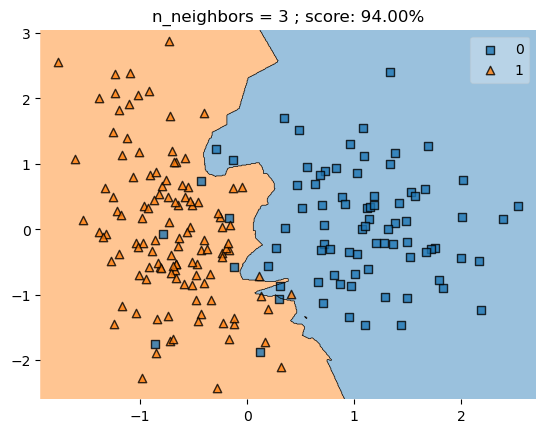

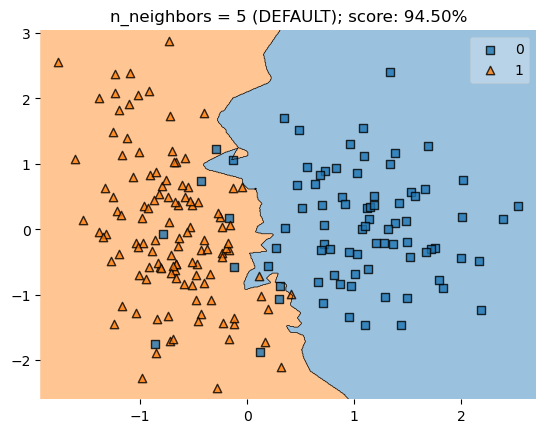

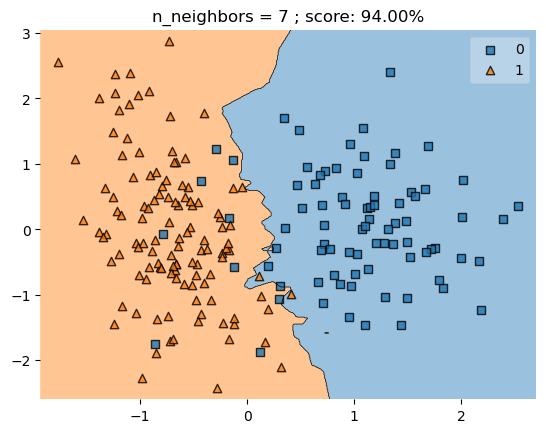

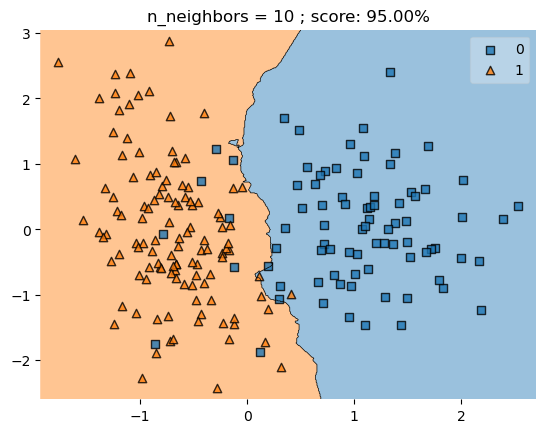

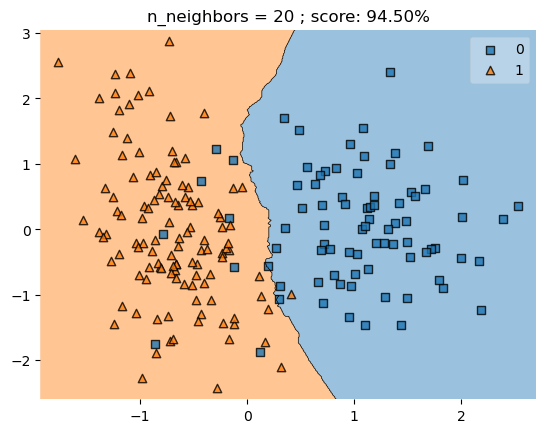

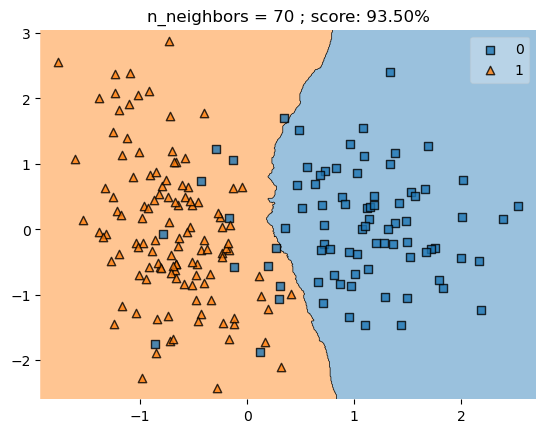

<Figure size 640x480 with 0 Axes>

In [65]:
for curr_n in [1, 3, 5, 7, 10, 20, 70]:
    knn_model = KNeighborsClassifier(n_neighbors = curr_n)

    knn_model.fit(X_scaled, y)
    
    plot_decision_regions(X=X_scaled.to_numpy(dtype=float), y=y, clf=knn_model, zoom_factor=6)

    score = cross_val_score(knn_model, X_scaled, y).mean()

    plt.title("n_neighbors = {} {}; score: {:.2f}%".format(curr_n, '(DEFAULT)' if curr_n == 5 else '', (score*100)))
    plt.figure()

# _(Grid-)Searching_ For The Right Parameters

The number of algorithms (and their respective hyperparameters) you have learned is growing and growing, making testing various combinations increasingly tedious when you have to resort to trial and error.

Luckily, _scikit-learn_ comes to help once again by providing `GridSearchCV`: a tool that tries out all combinations in a specified _grid_ of _parameters_ and finds the one with the best cross-validated performance.

The following example illustrates the `ParameterGrid`, that is used internally:

In [66]:
from sklearn.model_selection import ParameterGrid

In [67]:
param_grid = {'a': [1, 2, 3], 'b': [True, False], 'c': ['blue', 'white']}
list(ParameterGrid(param_grid))

[{'a': 1, 'b': True, 'c': 'blue'},
 {'a': 1, 'b': True, 'c': 'white'},
 {'a': 1, 'b': False, 'c': 'blue'},
 {'a': 1, 'b': False, 'c': 'white'},
 {'a': 2, 'b': True, 'c': 'blue'},
 {'a': 2, 'b': True, 'c': 'white'},
 {'a': 2, 'b': False, 'c': 'blue'},
 {'a': 2, 'b': False, 'c': 'white'},
 {'a': 3, 'b': True, 'c': 'blue'},
 {'a': 3, 'b': True, 'c': 'white'},
 {'a': 3, 'b': False, 'c': 'blue'},
 {'a': 3, 'b': False, 'c': 'white'}]

So we just need to create a simple dictionary of parameters we want to try out and feed them to `GridSearchCV`, along with the _estimator_ (in our case the classifier), the scoring strategy and the number of folds to be used for cross-validation. Afterwards we call the `fit` method with our data to start the search:

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
knn_param_grid = [
    {
        "n_neighbors": range(1, 30),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
    }
]

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    cv=5,
    scoring="accuracy",
)

grid_search.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['euclidean', 'manhattan'],
                          'n_neighbors': range(1, 30),
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

When the search is finished, we can retrieve the best combination along with the score as follows:

In [70]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)
0.9550000000000001


# _Pipelines_

![](images/waittheresmore.png)

As you know, hyperparameters are only one of the cogs affecting the performance of our models: As we demonstrated earlier in this demo, the preprocessing (_imputing_, _encoding_, _scaling_...) we apply has a _huge_ impact as well.

This is where _pipelines_ come into play: a `Pipeline` consists of a list of _transforms_ (i.e. objects implementing `fit` and `transform` methods) and a final _estimator_, that are _sequentially_ applied. They allow us to assemble several steps that can be parameterized and evaluated together - or even switched out altogheter.

E.g. we could easily test the effect of various _scaling_ techniques by changing the `Scaler` in the following pipeline:

In [71]:
from sklearn.pipeline import Pipeline

In [72]:
pipeline = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("knn", KNeighborsClassifier())
    ]
)

After specifying the steps in the pipeline, we can simply pass it as a whole as `estimator` when performing a grid-search. Note the _double underscore_ we use to specify the parameters of a pipeline-step by their _name_ (e.g. `knn__`):

In [73]:
knn_param_grid = [{'knn__n_neighbors': range(1,30),
                   'knn__weights': ['uniform', 'distance'],
                   'knn__metric': ['euclidean', 'manhattan']}]

grid_search = GridSearchCV(estimator=pipeline, param_grid=knn_param_grid, cv=5, scoring='accuracy')

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'knn__metric': 'euclidean', 'knn__n_neighbors': 4, 'knn__weights': 'uniform'}
0.95


# Revisiting _Stroke_ - With Pipelines

![](images/stroke.jpeg)

Let's return to our _stroke_-dataset to see how we can apply our newly gained knowledge. For simplicity, we'll be working with a _resampled_ version this time:

In [74]:
data = pd.read_csv('stroke_resampled.csv')

In [75]:
X = data.iloc[:,:-1]
y = data['stroke']

y.value_counts()

stroke
0    249
1    249
Name: count, dtype: int64

In [76]:
data.sample(10, random_state=my_random_state)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
321,Female,66.0,1,0,Yes,Govt_job,Rural,116.55,31.1,formerly smoked,1
76,Female,49.0,0,1,Yes,Private,Rural,76.78,22.7,smokes,0
388,Female,75.0,0,0,Yes,Private,Rural,199.20,26.6,Unknown,1
302,Female,77.0,1,0,Yes,Self-employed,Urban,124.13,31.4,never smoked,1
472,Female,81.0,0,0,No,Govt_job,Urban,70.30,25.8,smokes,1
131,Male,54.0,0,0,Yes,Private,Rural,109.51,29.0,never smoked,0
355,Female,50.0,1,0,Yes,Private,Rural,73.18,30.3,formerly smoked,1
337,Male,47.0,0,0,Yes,Private,Urban,86.94,41.1,formerly smoked,1
410,Male,71.0,0,1,Yes,Private,Urban,81.76,NaN,smokes,1
49,Male,31.0,0,0,Yes,Private,Urban,108.62,NaN,smokes,0


This dataset is perfect for experimenting with pipelines, because of the many preprocessing steps required:

* We have the binary categorical variables `gender`, `ever_married` and `Residence_type`.
* The categorical `smoking_status` column contains `Unknown` values and can be ranked (i.e. ordinal data).
* In contrast, the `work_type` column contains values with no ordering, requiring _one-hot_-encoding.
* The `bmi` has missing values requiring imputation.
* We probably should apply scaling, when training certain algorithms.

We can actually combine all of those steps in a `ColumnTransformer`, that allows us to perform different _transforms_ on different groups of columns. The results of each transformation are concatenated into a single feature space - since columns not specified are dropped by default, you need to make sure to use `remainder='passthrough'`, so that columns not affected by any transformations are simply passed through.

Also note, that we need to make sure, that the missing values in the `smoking_status`-column are imputed _before_ we apply encoding. We can accomplish this by defining a smaller pipeline as shown in the example below.

In [77]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [78]:
pipeline_smoking = Pipeline(steps=[
    ('smoking_imputer', SimpleImputer(strategy='constant', fill_value='never smoked', missing_values='Unknown')),
    ('smoking_encoding', OrdinalEncoder(categories=[['never smoked', 'formerly smoked', 'smokes']]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('smoking', pipeline_smoking, ['smoking_status']),
        ('binary_categories', OrdinalEncoder(), ['gender', 'ever_married', 'Residence_type']),
        ('work_type', OneHotEncoder(handle_unknown='ignore'), ['work_type']),
        ('bmi', SimpleImputer(strategy='median'), ['bmi'])
    ],
    remainder='passthrough' # This is important, see above!
)

Before creating and using the final pipeline, it makes sense to test the `ColumnTransformer`:

In [79]:
pd.DataFrame(preprocessor.fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,28.60,49.0,0.0,0.0,199.96
1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,31.30,40.0,0.0,0.0,158.93
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,41.10,17.0,0.0,0.0,68.86
3,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,24.70,45.0,0.0,0.0,110.47
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,24.00,30.0,0.0,0.0,61.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,36.70,57.0,0.0,0.0,84.96
494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,30.90,14.0,0.0,0.0,57.93
495,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,29.30,75.0,0.0,0.0,78.80
496,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,28.95,71.0,1.0,0.0,87.80


When you're sure your preprocesser works as desired, you can simply integrate it into a pipeline as follows:

In [80]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler()),
        ('knn', KNeighborsClassifier())
    ]
)

Since creating big pipelines can get confusing, _scikit-learn_ provides a neat way of visualizing them:

In [81]:
from sklearn import set_config

In [82]:
set_config(display='diagram')
pipeline

c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('smoking',
                                                  Pipeline(steps=[('smoking_imputer',
                                                                   SimpleImputer(fill_value='never '
                                                                                            'smoked',
                                                                                 missing_values='Unknown',
                                                                                 strategy='constant')),
                                                                  ('smoking_encoding',
                                                                   OrdinalEncoder(categories=[['never '
                                                                                               'smoked',
                                                                                               'formerly '
                                                                                               'smoked',
                                                                                               'smokes']]))]),
                                                  ['smoking_status']),
                                                 ('binary_categories',
                                                  OrdinalEncoder(),
                                                  ['gender', 'ever_married',
                                                   'Residence_type']),
                                                 ('work_type',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['work_type']),
                                                 ('bmi',
                                                  SimpleImputer(strategy='median'),
                                                  ['bmi'])])),
                ('scaler', RobustScaler()), ('knn', KNeighborsClassifier())])

Let's finally try out our pipeline! Note, that we can even specify parameters for the single steps of our preprocessor - such as the imputation strategy or replacement values. Unfortunately this increase in search space might result in longer waiting times...

In [83]:
knn_param_grid = [{ 'preprocessor__smoking__smoking_imputer__fill_value': ['never smoked', 'formerly smoked', 'smokes'],
                    'preprocessor__bmi__strategy': ['median', 'mean'],
                    'knn__n_neighbors': range(1,30),
                    'knn__weights': ['uniform', 'distance'],
                    'knn__metric': ['euclidean', 'manhattan']}]

grid_search = GridSearchCV(estimator=pipeline, param_grid=knn_param_grid, cv=5, scoring='f1')

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'knn__metric': 'manhattan', 'knn__n_neighbors': 21, 'knn__weights': 'uniform', 'preprocessor__bmi__strategy': 'median', 'preprocessor__smoking__smoking_imputer__fill_value': 'formerly smoked'}
0.7824567424567425


With the preprocessing steps bundled in the `ColumnTransformer`, we can now use `GridSearchCV` to find the best parameter combinations for the other algorithms you've gotten to know so far:

## _Decision Tree_

This is a good moment to think, whether scaling the features affects the training process or performance of a decision tree. Try adding/removing a `Scaler` to the pipeline to confirm your assumption:

In [84]:
from sklearn.tree import DecisionTreeClassifier

In [85]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dt', DecisionTreeClassifier(random_state=my_random_state))
    ]
)

dt_param_grid = [{ 'preprocessor__smoking__smoking_imputer__fill_value': ['never smoked', 'formerly smoked', 'smokes'],
                    'preprocessor__bmi__strategy': ['median', 'mean'],
                    'dt__criterion': ['gini', 'entropy'],
                    'dt__max_depth': range(1, 20),
                    'dt__min_samples_leaf': range(1,20)}]

grid_search = GridSearchCV(pipeline, dt_param_grid, cv=5, scoring='f1')

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
# Result without scaling:
# {'dt__criterion': 'entropy', 'dt__max_depth': 4, 'dt__min_samples_leaf': 14, 'preprocessor__bmi__strategy': 'median', 'preprocessor__smoking__smoking_imputer__fill_value': 'never smoked'}
# 0.8017026217026217
# Result with RobustScaler:
# {'dt__criterion': 'entropy', 'dt__max_depth': 4, 'dt__min_samples_leaf': 14, 'preprocessor__bmi__strategy': 'median', 'preprocessor__smoking__smoking_imputer__fill_value': 'never smoked'}
# 0.8031768231768233

## _Random Forest_

Hint: Now is a good moment to get coffee, this might take a while.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(random_state=my_random_state))
    ]
)

rf_param_grid = { 'preprocessor__smoking__smoking_imputer__fill_value': ['never smoked', 'formerly smoked', 'smokes'],
                    'preprocessor__bmi__strategy': ['median', 'mean'],
                    'rf__criterion': ['gini', 'entropy'],
                   'rf__max_depth': range(1, 20),
                    'rf__min_samples_leaf': range(1,20)}

grid_search = GridSearchCV(pipeline, rf_param_grid, cv=5, scoring='f1')

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

In [ ]:
# Result without scaling:
# {'preprocessor__bmi__strategy': 'mean', 'preprocessor__smoking__smoking_imputer__fill_value': 'never smoked', 'rf__criterion': 'gini', 'rf__max_depth': 9, 'rf__min_samples_leaf': 7}
# 0.81189220210751
# Result with RobustScaler:
# {'preprocessor__bmi__strategy': 'median', 'preprocessor__smoking__smoking_imputer__fill_value': 'never smoked', 'rf__criterion': 'gini', 'rf__max_depth': 8, 'rf__min_samples_leaf': 7}
# 0.8103345697087562

## _Support Vector Machine_

Again, take a moment to reflect on how the inner workings of _SVMs_ would be affected by scaled/unscaled features. Next, take a look at the answer below the code block.

In [ ]:
from sklearn.svm import SVC

In [ ]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("scaler", RobustScaler()),
        ("svm", SVC(random_state=my_random_state))
    ]
)

svm_param_grid = { 'preprocessor__smoking__smoking_imputer__fill_value': ['never smoked', 'formerly smoked', 'smokes'],
                    'preprocessor__bmi__strategy': ['median', 'mean'],
                    'svm__C': [0.1, 1, 10, 100, 1000],
                  'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'svm__kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(pipeline, svm_param_grid, cv=5, scoring='f1')

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__bmi__strategy': 'median', 'preprocessor__smoking__smoking_imputer__fill_value': 'smokes', 'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.8018617526099335


In [ ]:
# Result without scaling:
# Since SVMs are distance-based, it is crucial to scale the data. Not only for the performance -
# - it also seems to have an influence on the training time, which is _extremely_ high in our example.
# Result with RobustScaler:
# {'preprocessor__bmi__strategy': 'median', 'preprocessor__smoking__smoking_imputer__fill_value': 'smokes', 'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
# 0.8018617526099335

# Conclusion

This has grown into quite a large demo. We have covered...

* ...how to create artificial datasets for experimenting.
* ...how simple the idea behind the _k-Nearest-Neighbors_-algorithm is.
* ...how unscaled features affect distance-based algorithms.
* ...three different approaches for scaling features.
* ...how we can use `GridSearchCV`, `Pipeline`s and `ColumnTransformer`s to assemble several steps that can be cross-validated together on the hunt for the best combination of parameters and preprocessing steps.